In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


2023-08-11 06:20:59.279859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 06:21:00.411116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [4]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/bin/bash: /home/amira/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/amira/.keras/datasets
/home/amira/.keras/datasets/cats_and_dogs_filtered
/home/amira/.keras/datasets/cats_and_dogs_filtered/train
/home/amira/.keras/datasets/cats_and_dogs_filtered/train/dogs
/home/amira/.keras/datasets/cats_and_dogs_filtered/train/cats
/home/amira/.keras/datasets/cats_and_dogs_filtered/validation
/home/amira/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/home/amira/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [17]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


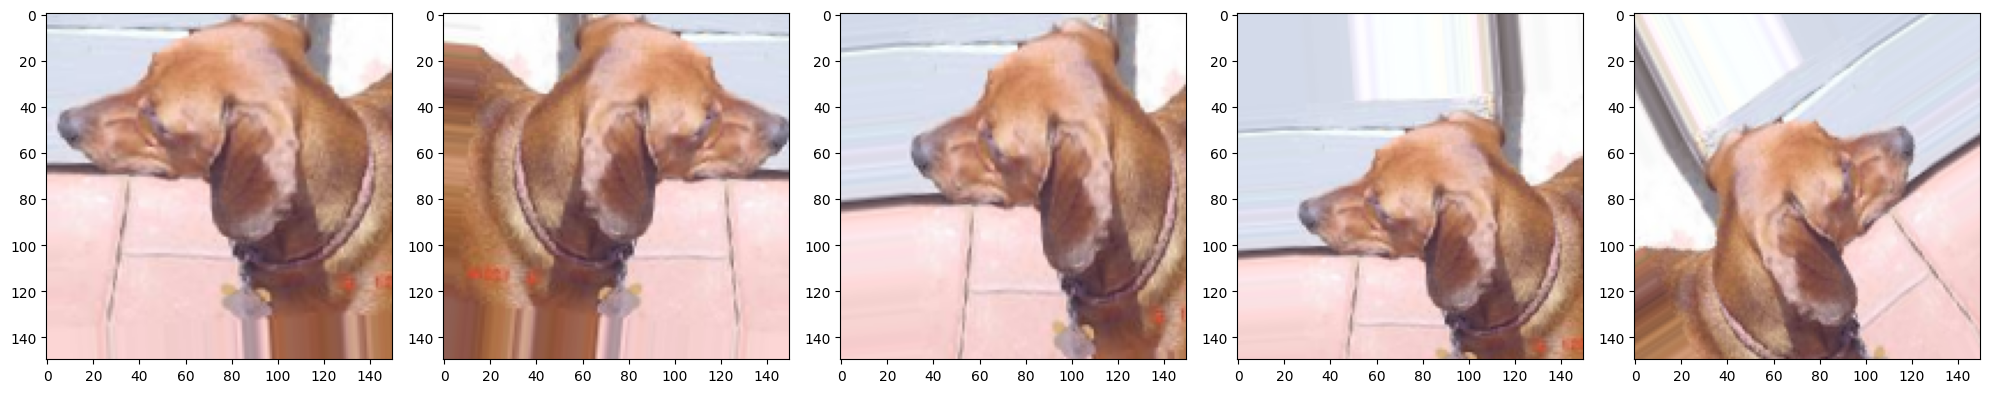

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [11]:
sample_training_images, _ = next(train_data_gen) 

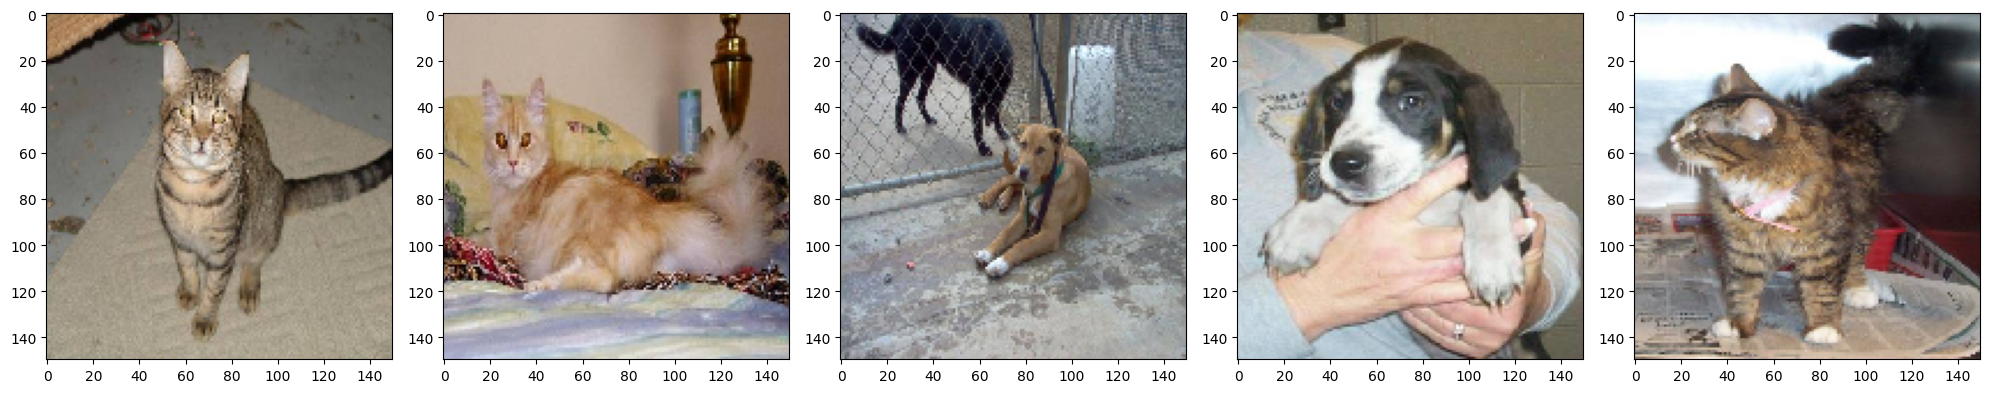

In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [24]:
EPOCHS = 20
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/20


2023-08-11 06:29:22.732511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-11 06:29:23.495757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-11 06:29:24.287335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-11 06:29:24.498361: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-11 06:29:25.509383: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59GiB w

 6/20 [========>.....................] - ETA: 7s - loss: 0.7639 - accuracy: 0.4883

2023-08-11 06:29:38.535627: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27000000 exceeds 10% of free system memory.


 8/20 [===========>..................] - ETA: 6s - loss: 0.7469 - accuracy: 0.4837

2023-08-11 06:29:39.561277: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27000000 exceeds 10% of free system memory.


11/20 [===============>..............] - ETA: 4s - loss: 0.7341 - accuracy: 0.4864

2023-08-11 06:29:41.132607: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27000000 exceeds 10% of free system memory.


12/20 [=================>............] - ETA: 4s - loss: 0.7305 - accuracy: 0.4900

2023-08-11 06:29:41.640474: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27000000 exceeds 10% of free system memory.


13/20 [==================>...........] - ETA: 3s - loss: 0.7277 - accuracy: 0.4908

2023-08-11 06:29:42.154211: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27000000 exceeds 10% of free system memory.


20/20 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.4990

2023-08-11 06:29:45.888994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 24s 591ms/step - loss: 0.7158 - accuracy: 0.4990 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 12s 574ms/step - loss: 0.6907 - accuracy: 0.5195 - val_loss: 0.6840 - val_accuracy: 0.5880
Epoch 3/20
20/20 [==============================] - 12s 587ms/step - loss: 0.6874 - accuracy: 0.5555 - val_loss: 0.6786 - val_accuracy: 0.5000
Epoch 4/20
20/20 [==============================] - 13s 609ms/step - loss: 0.6672 - accuracy: 0.5475 - val_loss: 0.6535 - val_accuracy: 0.6250
Epoch 5/20
20/20 [==============================] - 12s 604ms/step - loss: 0.6734 - accuracy: 0.5650 - val_loss: 0.6360 - val_accuracy: 0.6250
Epoch 6/20
20/20 [==============================] - 12s 595ms/step - loss: 0.6521 - accuracy: 0.5925 - val_loss: 0.6786 - val_accuracy: 0.5680
Epoch 7/20
20/20 [==============================] - 14s 693ms/step - loss: 0.6501 - accuracy: 0.6250 - val_loss: 0.6506 - val_accuracy: 0.5500
Epoch 8/20

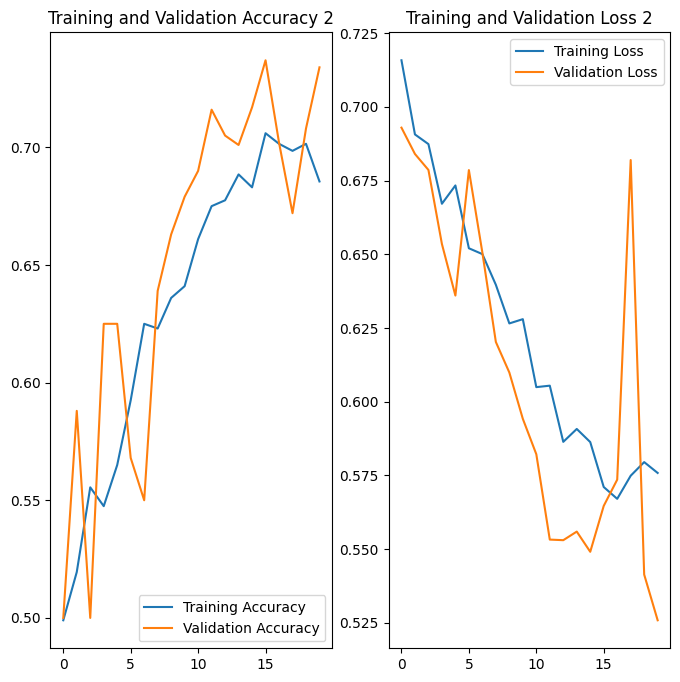

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy 2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss 2')
plt.savefig('./cat-dog-result2.png')
plt.show()